In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install numpy scikit-learn
!pip install -q torch_geometric
!pip install -q class_resolver
!pip3 install pymatting
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.5 MB/s eta 0:00:00


In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [3]:
# Load CN and MCI feature data
cn_fa_feature_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_CN_dataset/Processed_histogram_features_CN_All/Histogram_CN_FA_20bin_updated.npy"
mci_fa_feature_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_MCI_dataset/Processed_histogram_features_MCI_All/Histogram_MCI_FA_20bin_updated.npy"

Histogram_feature_CN_FA = np.load(cn_fa_feature_path, allow_pickle=True)
Histogram_feature_MCI_FA = np.load(mci_fa_feature_path, allow_pickle=True)

In [4]:
X_cn = Histogram_feature_CN_FA
X_mci = Histogram_feature_MCI_FA

y_cn = np.zeros(X_cn.shape[0])   # CN = 0
y_mci = np.ones(X_mci.shape[0])  # MCI = 1

# Combine data
X = np.vstack((X_cn, X_mci))
y = np.hstack((y_cn, y_mci))

In [5]:
np.random.seed(42)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]

In [6]:
# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
# 20 stratified splits (10% train, 90% test per fold)
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.3, random_state=42)

In [8]:
# Metric storage
accuracies, precisions, recalls, f1_scores, losses = [], [], [], [], []

In [9]:
all_y_true = []
all_y_proba = []
all_fpr = []
all_tpr = []
all_auc = []
# Loop over folds
for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold + 1}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf = RandomForestClassifier(n_estimators=200, max_depth=50, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    loss = log_loss(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    losses.append(loss)
    all_y_true.extend(y_test)
    all_y_proba.extend(y_pred_proba)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(auc_score)

    print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Loss: {loss:.4f} | AUC: {auc_score:.4f}")

# Final average results
print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")


Training fold 1
Accuracy: 0.8111 | Precision: 0.8235 | Recall: 0.8400 | F1: 0.8317 | Loss: 0.4523 | AUC: 0.8810

Training fold 2
Accuracy: 0.8556 | Precision: 0.8627 | Recall: 0.8800 | F1: 0.8713 | Loss: 0.4212 | AUC: 0.9223

Training fold 3
Accuracy: 0.8000 | Precision: 0.8077 | Recall: 0.8400 | F1: 0.8235 | Loss: 0.4700 | AUC: 0.8775

Training fold 4
Accuracy: 0.8333 | Precision: 0.8571 | Recall: 0.8400 | F1: 0.8485 | Loss: 0.4208 | AUC: 0.9090

Training fold 5
Accuracy: 0.8000 | Precision: 0.8077 | Recall: 0.8400 | F1: 0.8235 | Loss: 0.4204 | AUC: 0.9160

Training fold 6
Accuracy: 0.7444 | Precision: 0.8000 | Recall: 0.7200 | F1: 0.7579 | Loss: 0.4649 | AUC: 0.8602

Training fold 7
Accuracy: 0.8111 | Precision: 0.8511 | Recall: 0.8000 | F1: 0.8247 | Loss: 0.4403 | AUC: 0.8945

Training fold 8
Accuracy: 0.8222 | Precision: 0.8864 | Recall: 0.7800 | F1: 0.8298 | Loss: 0.4473 | AUC: 0.9018

Training fold 9
Accuracy: 0.8333 | Precision: 0.8723 | Recall: 0.8200 | F1: 0.8454 | Loss: 0.43

In [ ]:
all_y_true = []
all_y_proba = []
all_fpr = []
all_tpr = []
all_auc = []
# Loop over folds
for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold + 1}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf = RandomForestClassifier(n_estimators=200, max_depth=50, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    loss = log_loss(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    losses.append(loss)
    all_y_true.extend(y_test)
    all_y_proba.extend(y_pred_proba)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(auc_score)

    print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Loss: {loss:.4f} | AUC: {auc_score:.4f}")

# Final average results
print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")


Training fold 1
Accuracy: 0.7667 | Precision: 0.8077 | Recall: 0.7590 | F1: 0.7826 | Loss: 0.4871 | AUC: 0.8483

Training fold 2
Accuracy: 0.7800 | Precision: 0.7865 | Recall: 0.8333 | F1: 0.8092 | Loss: 0.4630 | AUC: 0.8813

Training fold 3
Accuracy: 0.7800 | Precision: 0.8289 | Recall: 0.7590 | F1: 0.7925 | Loss: 0.4729 | AUC: 0.8664

Training fold 4
Accuracy: 0.8067 | Precision: 0.7935 | Recall: 0.8795 | F1: 0.8343 | Loss: 0.4595 | AUC: 0.8934

Training fold 5
Accuracy: 0.8000 | Precision: 0.8000 | Recall: 0.8571 | F1: 0.8276 | Loss: 0.4522 | AUC: 0.8885

Training fold 6
Accuracy: 0.8267 | Precision: 0.8701 | Recall: 0.8072 | F1: 0.8375 | Loss: 0.4379 | AUC: 0.8970

Training fold 7
Accuracy: 0.7733 | Precision: 0.7634 | Recall: 0.8554 | F1: 0.8068 | Loss: 0.4776 | AUC: 0.8688

Training fold 8
Accuracy: 0.8000 | Precision: 0.8354 | Recall: 0.7952 | F1: 0.8148 | Loss: 0.4859 | AUC: 0.8606

Training fold 9
Accuracy: 0.7800 | Precision: 0.7684 | Recall: 0.8690 | F1: 0.8156 | Loss: 0.45

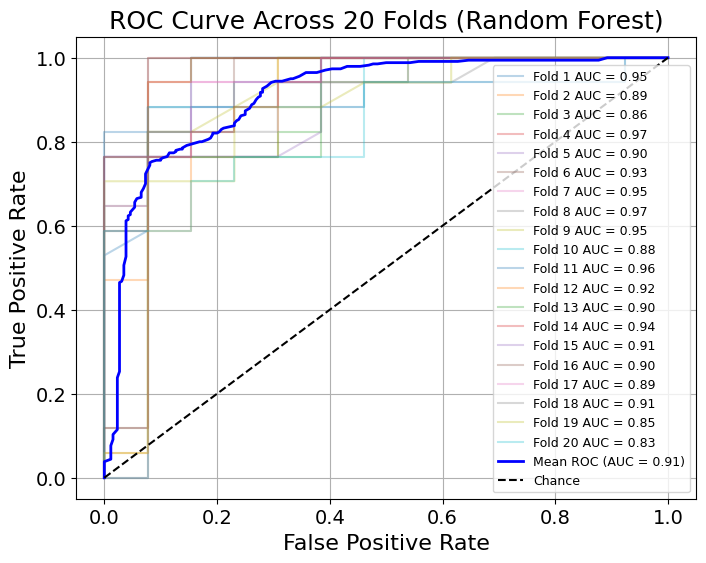

In [ ]:
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

# Average ROC Curve
fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC Curve Across 20 Folds (Random Forest)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)